In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import os
import csv
import re
from tqdm import tqdm
import requests
import parsel
import threading
from datetime import timedelta

import statsmodels.api as sm
from scipy.stats import norm, skew

import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp 
import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sklearn
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## import data

In [2]:
d1 = pd.read_excel("msoa-data-old.xlsx")
d2 = pd.read_excel("land-house-price.xlsx")
d3 = pd.read_excel("income.xlsx")
d4 = pd.merge(d1,d2[['Code','price']],on = "Code",how = 'left')
d5 = pd.merge(d4,d3[['Code','Total Mean Annual Household Income estimate']],on = "Code",how = 'left')

In [3]:
d5['area'] = d5['MSOA Name'].apply(lambda x:re.sub(r'\d+',"", x))
d5['area'] = d5['area'].apply(lambda x:x.rstrip())
d5['area'] = d5['area'].apply(lambda x:x.lstrip())
d6  = d5.dropna()
d6.columns = pd.Series(d6.columns).replace(" ","_",regex = True)
#d5 = d4.iloc[:,2:7]
d7 = d6.iloc[:,2:9]

In [4]:
d7.columns
d7['income'] = d7['Total_Mean_Annual_Household_Income_estimate']

In [5]:
d8 =d7.groupby(['area']).sum().reset_index()
d8['price'] =  d7.groupby(['area'])['price'].mean().values
d8['income'] =  d7.groupby(['area'])['Total_Mean_Annual_Household_Income_estimate'].mean().values

In [6]:
d9 = d8[['area','population', 'Total_Notifiable_Offences','Number_in_employment_(workplace)', 'Claimant_Count', 'price','income']]

## Describe

In [7]:
d9.describe()

,population,Total_Notifiable_Offences,Number_in_employment_(workplace),Claimant_Count,price,income
count,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000
mean,246870.250000,22717.937500,119204.000000,121.785431,3.851952e+05,46381.506797
std,54561.476918,9767.231476,108957.210757,53.849071,2.075763e+05,8613.228228
min,158649.000000,10372.000000,46582.000000,32.442388,1.749878e+05,33333.373385
25%,208108.750000,16148.500000,67522.500000,82.242392,2.620452e+05,41497.787479
50%,240514.500000,22405.500000,92721.500000,111.638988,3.266916e+05,43216.941003
75%,289542.750000,26419.000000,118927.750000,166.371411,4.108405e+05,51323.397697
max,356386.000000,61875.000000,642498.000000,244.865980,1.184658e+06,69772.365026


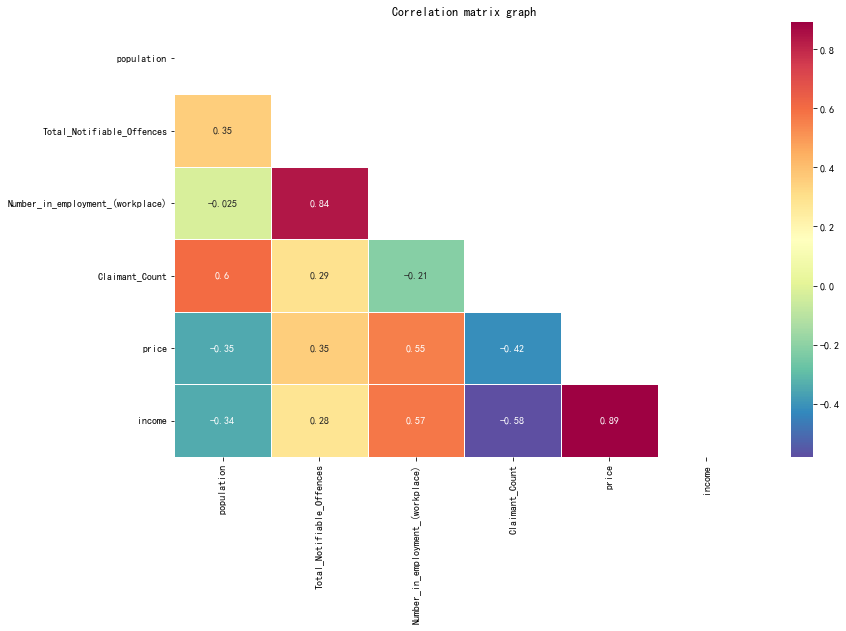

In [8]:
corr = d9.iloc[:, 1:].corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
plt.figure(figsize = (13, 8))
plt.title('Correlation matrix graph')
sns.heatmap(corr, mask = mask, cmap = 'Spectral_r', linewidths = .5, annot = True)
#plt.text(11, 14.5, caption, size = 12)
plt.show()

array([[<Axes: xlabel='population', ylabel='population'>,
        <Axes: xlabel='Total Notifiable Offences', ylabel='population'>,
        <Axes: xlabel='Number in employment (workplace)', ylabel='population'>,
        <Axes: xlabel='Claimant Count', ylabel='population'>,
        <Axes: xlabel='price', ylabel='population'>,
        <Axes: xlabel='Total Mean Annual Household Income estimate', ylabel='population'>],
       [<Axes: xlabel='population', ylabel='Total Notifiable Offences'>,
        <Axes: xlabel='Total Notifiable Offences', ylabel='Total Notifiable Offences'>,
        <Axes: xlabel='Number in employment (workplace)', ylabel='Total Notifiable Offences'>,
        <Axes: xlabel='Claimant Count', ylabel='Total Notifiable Offences'>,
        <Axes: xlabel='price', ylabel='Total Notifiable Offences'>,
        <Axes: xlabel='Total Mean Annual Household Income estimate', ylabel='Total Notifiable Offences'>],
       [<Axes: xlabel='population', ylabel='Number in employment (workplac

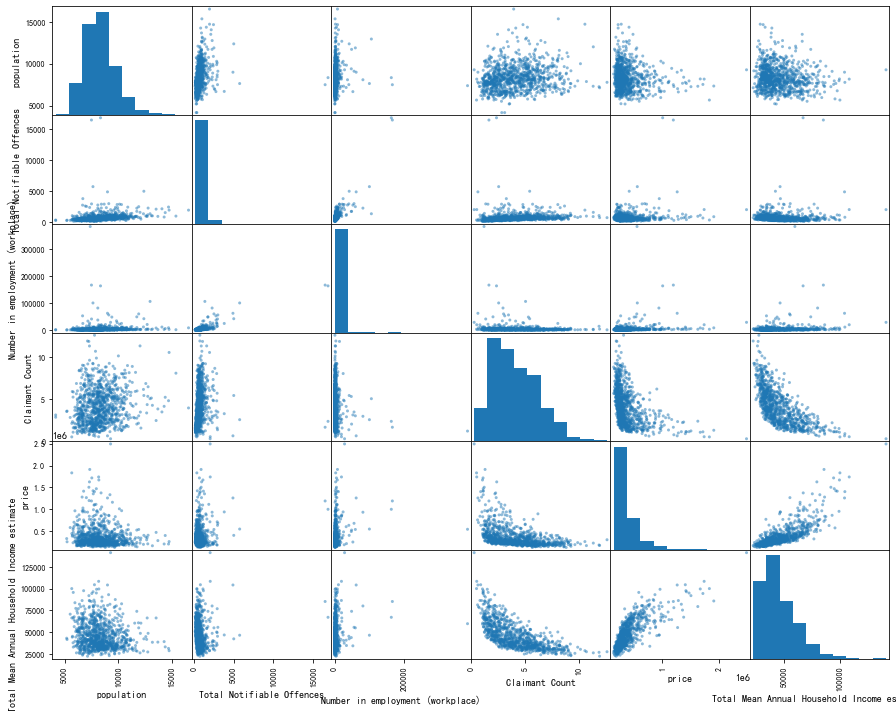

In [9]:
corr = d9.iloc[:, 1:].corr()
abs(corr).sort_values(by = 'price', ascending = False)['price']
pd.plotting.scatter_matrix(d5, figsize=(15,12))

In [10]:
dx =  d9[['population', 'Total_Notifiable_Offences',
       'Number_in_employment_(workplace)', 'Claimant_Count', 'price',
       'income']]

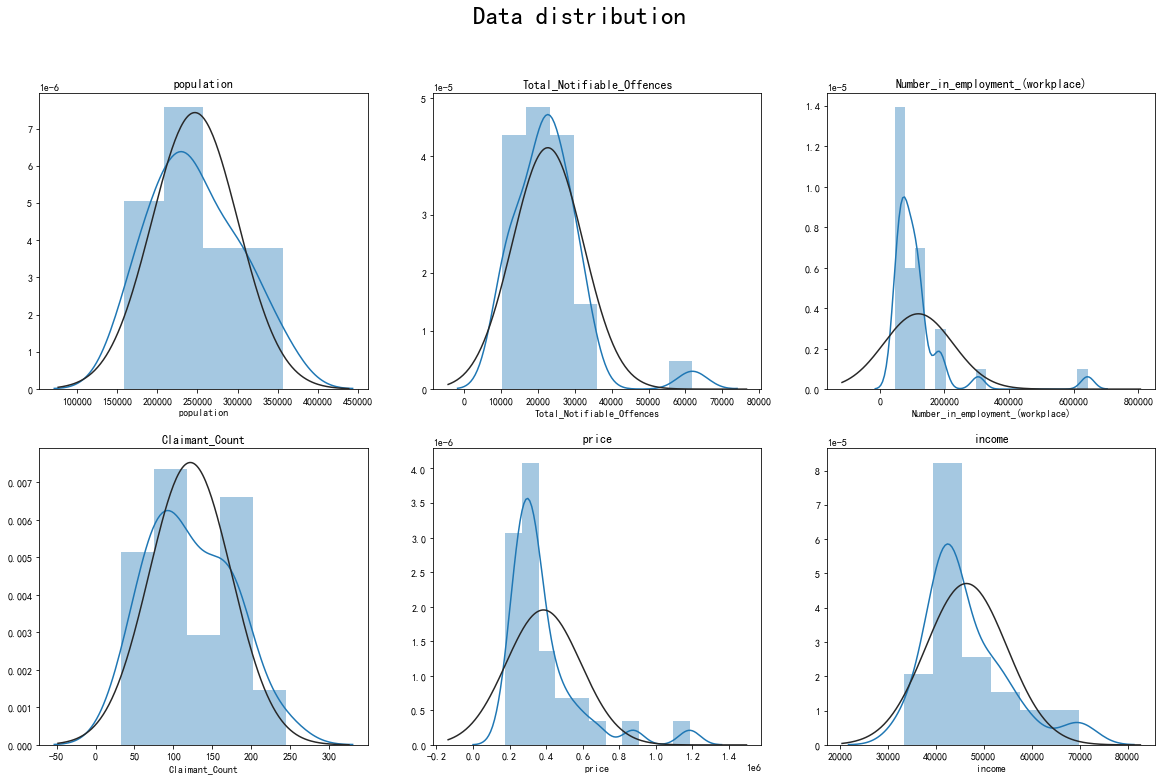

In [11]:
fig = plt.figure(figsize = (20, 12))
fig.suptitle('Data distribution', size = 25, weight = 'bold')
for idx, i in enumerate(dx.columns):
    fig.add_subplot(2, 3, idx+1)
    sns.distplot(dx.iloc[:, idx], fit=norm)
   # df.iloc[:, idx].hist(bins = 20)
    plt.title(i)
    plt.grid(False)
#plt.text(1000, -200,  size = 12)
plt.show()

## OLS

In [12]:
X_train = d9[['population', 'Total_Notifiable_Offences','Number_in_employment_(workplace)', 'Claimant_Count','income']]
y_train = d9[['price']]

X = X_train
y = y_train
result = sm.OLS(y,sm.add_constant(X)).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     27.89
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           1.14e-09
Time:                        22:34:41   Log-Likelihood:                -407.07
No. Observations:                  32   AIC:                             826.1
Df Residuals:                      26   BIC:                             834.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                            -5.693e+05   1.74e+05     -3.268      0.003   -9.27e+05   -2.11e+05
population                          -0.8776      0.414     -2.118      0.044      -1.729      -0.026
Total_Notifiable_Offences           10.0445      7.587      1.324      0.197      -5.550      25.639
Number_in_employment_(workplace)    -0.6802      0.638     -1.067      0.296      -1.991       0.630
Claimant_Count                     119.0918    755.747      0.158      0.876   -1434.369    1672.553
income                              21.7654      2.863      7.603      0.000      15.881      27.650
==============================================================================
Omnibus:                       10.669   Durbin-Watson:                   2.363
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                9.654
Skew:                           1.111   Prob(JB):                      0.00801
Kurtosis:                       4.517   Cond. No.                     3.15e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

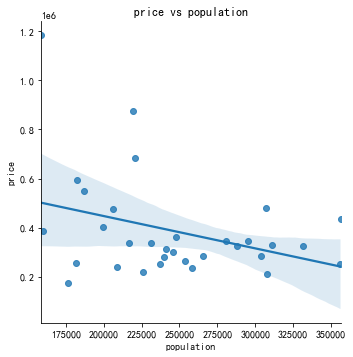

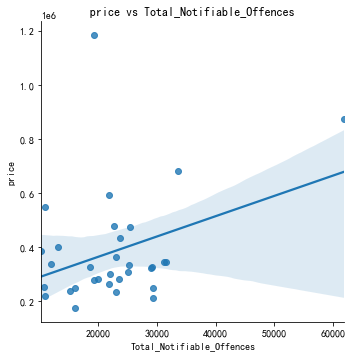

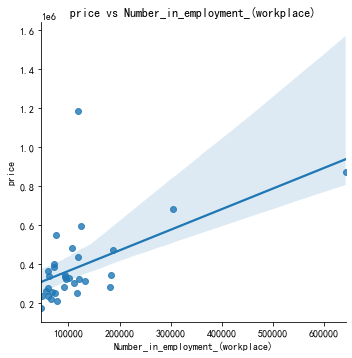

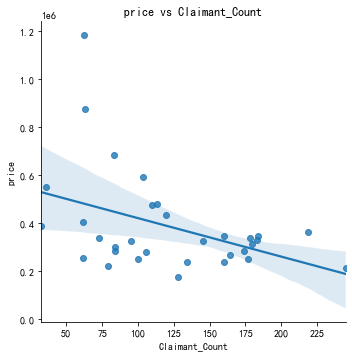

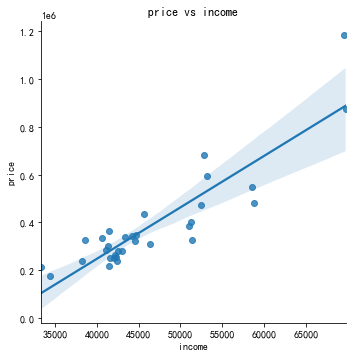

In [13]:
cols = ['population', 'Total_Notifiable_Offences','Number_in_employment_(workplace)', 'Claimant_Count','income']

for i in cols:
    sns.lmplot(x= i, y="price", data=d9)
    plt.title("price vs {}".format(i))
    


In [14]:
Selected_Features = []
def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    return (Selected_Features[0])


In [15]:
select = backward_regression(X_train, y_train)
X = X_train[select]
y = y_train
result = sm.OLS(y,sm.add_constant(X)).fit()
result.summary()

worst_feature : Claimant_Count, 0.8760040305308532 
worst_feature : Number_in_employment_(workplace), 0.06772781514683146 
worst_feature : population, 0.17646882650441062 
worst_feature : Total_Notifiable_Offences, 0.19573043327716672 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     118.4
Date:                Sun, 27 Aug 2023   Prob (F-statistic):           6.19e-12
Time:                        22:34:43   Log-Likelihood:                -411.11
No. Observations:                  32   AIC:                             826.2
Df Residuals:                      30   BIC:                             829.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.132e+05   9.33e+04     -6.574      0.000   -8.04e+05   -4.23e+05
income        21.5259      1.978     10.880      0.000      17.485      25.567
==============================================================================
Omnibus:                        9.413   Durbin-Watson:                   2.765
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.844
Skew:                           0.884   Prob(JB):                       0.0120
Kurtosis:                       4.872   Cond. No.                     2.62e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.62e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## kmeans

In [16]:
from sklearn.preprocessing import StandardScaler
d10 = d9.iloc[:,1:].copy()
scaler = StandardScaler()
      
for i in d10.columns:
    d10[i] = scaler.fit_transform(d10[i].values.reshape(-1, 1))     

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9).fit(d10)
x_pca = pca.transform(d10)

In [18]:
pca.explained_variance_ratio_

array([0.5013757 , 0.33096631, 0.08238536])

In [19]:
X = pd.DataFrame(x_pca)
X.columns = ['pc1','pc2','pc3']
X.head()

,pc1,pc2,pc3
0,-1.489513,-1.199352,-1.238605
1,-0.375891,1.103343,1.077939
2,-0.898202,-1.468252,-0.463032
3,-1.232583,1.563800,0.252302
4,-0.060963,-0.219627,0.597023


In [20]:
# Kmeans algorithm settings
kmeans_set = {"init":"random", "n_init":10, "max_iter":300, "random_state":42}

In [21]:
from sklearn.cluster import KMeans 
from sklearn import metrics
silhouette_score_coef = []
for k in tqdm(range(2,11)):
    kmeans = KMeans(n_clusters=k, **kmeans_set)
    kmeans.fit(X)
    score =  metrics.silhouette_score(X, kmeans.labels_)
    silhouette_score_coef.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 57.48it/s]


In [22]:
def plot_evaluation(db_score,name, x=range(2,11)):
    plt.plot(x, db_score, marker='o')
    plt.ylabel("silhouette_score Coefficient", labelpad=20)
    plt.xlabel("Number of Clusters", labelpad=20)
    plt.title(f"Evaluate {name} Clustering")
    plt.show()

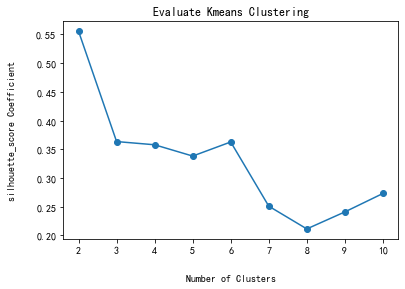

In [23]:
plot_evaluation(silhouette_score_coef,"Kmeans", x=range(2,11))

In [24]:
clusterer = KMeans(n_clusters=2, **kmeans_set).fit(X)
#clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(X)

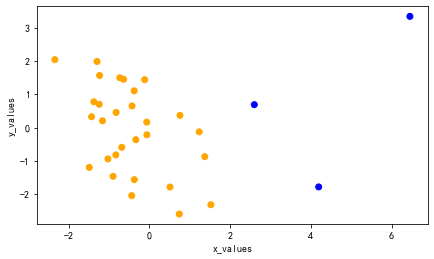

In [25]:
import matplotlib
fig = plt.figure(figsize=(7,4))
colors = ['orange','blue','purple','green','red','yellow','grey']
colored = [colors[k] for k in c_preds]
# print (colored[0:10])
plt.scatter(X["pc1"],X["pc2"],color = colored)
# for ci,c in enumerate(centers):
#     plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.show();

In [26]:
d9.describe()

,population,Total_Notifiable_Offences,Number_in_employment_(workplace),Claimant_Count,price,income
count,32.000000,32.000000,32.000000,32.000000,3.200000e+01,32.000000
mean,246870.250000,22717.937500,119204.000000,121.785431,3.851952e+05,46381.506797
std,54561.476918,9767.231476,108957.210757,53.849071,2.075763e+05,8613.228228
min,158649.000000,10372.000000,46582.000000,32.442388,1.749878e+05,33333.373385
25%,208108.750000,16148.500000,67522.500000,82.242392,2.620452e+05,41497.787479
50%,240514.500000,22405.500000,92721.500000,111.638988,3.266916e+05,43216.941003
75%,289542.750000,26419.000000,118927.750000,166.371411,4.108405e+05,51323.397697
max,356386.000000,61875.000000,642498.000000,244.865980,1.184658e+06,69772.365026


In [27]:
d9.columns

Index(['area', 'population', 'Total_Notifiable_Offences',
       'Number_in_employment_(workplace)', 'Claimant_Count', 'price',
       'income'],
      dtype='object')

In [28]:
for idx,i in enumerate(cols): 
    print(idx,i)

0 population
1 Total_Notifiable_Offences
2 Number_in_employment_(workplace)
3 Claimant_Count
4 income


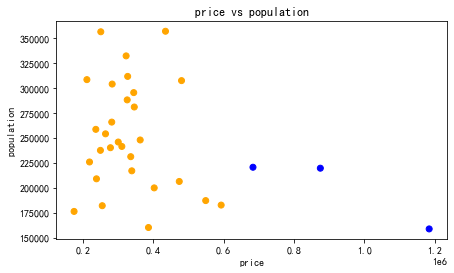

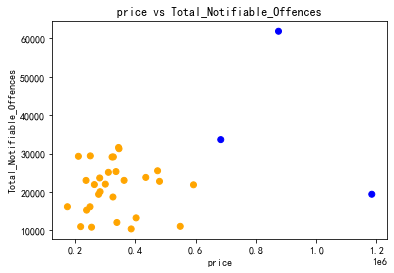

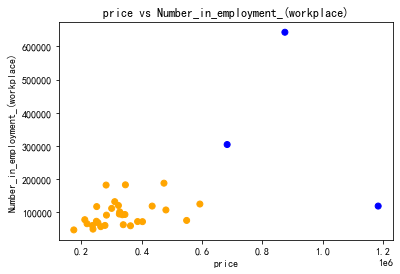

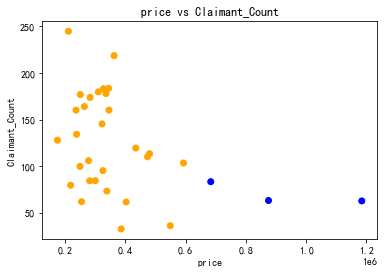

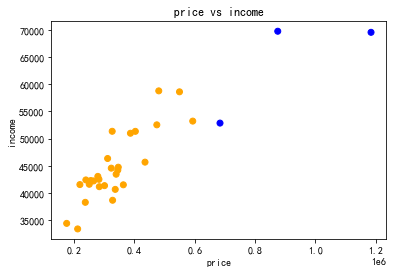

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib
fig = plt.figure(figsize=(7,4))
colors = ['orange','blue']
colored = [colors[k] for k in c_preds]
for i in cols:
    plt.scatter(d9["price"],d9[i],color = colored)
    plt.xlabel('price')
    plt.ylabel(i)
    plt.title("price vs {}".format(i))
    plt.show()
    
plt.tight_layout()   


In [30]:
d9['label'] = c_preds
d9.groupby(['label'])['area'].count().reset_index()

,label,area
0,0,29
1,1,3


In [31]:
a1 = d9.groupby(['label'])['income'].mean().reset_index()
a2 = d9.groupby(['label'])['price'].mean().reset_index()

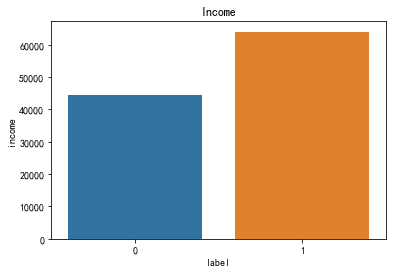

In [32]:
sns.barplot(x ='label',y = 'income',data=a1)
plt.title('Income');

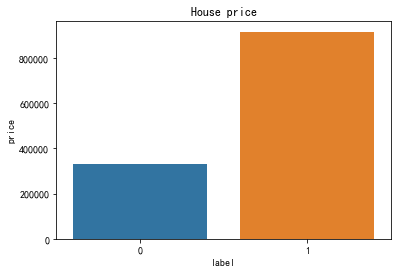

In [33]:
sns.barplot(x ='label',y = 'price',data=a2)
plt.title('House price');

## GWR

In [34]:
L = pd.read_excel("long_lat.xlsx",sheet_name = "Sheet2")
UTLA_X_Y  =  pd.read_csv("UTLA_X_Y.csv")
U = UTLA_X_Y[['areaName','long','lat']]
U.columns = ['area','long','lat']
d11 = pd.merge(d8,U,on = 'area',how = 'left')
d11['long'] = d11['long'].fillna(-0.0553)
d11['lat'] = d11['lat'].fillna(51.545)

In [35]:
len(d11['area'].unique())

32

In [36]:
dxx  =pd.merge(d7,U,on = 'area',how = 'left')
dxx['long'] = dxx['long'].fillna(-0.0553)
dxx['lat'] = dxx['lat'].fillna(51.545)

In [37]:
def judge(x):
    if x < np.mean(d11['long']) :
        return 1
    else :
        return 2
d11['part'] = d11['long'].apply(judge)

In [38]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


In [39]:
UTLA_1 = d11.copy()
g_y = UTLA_1['price'].values.reshape((-1,1))
g_X = UTLA_1[['income','population', 'Total_Notifiable_Offences',
       'Number_in_employment_(workplace)', 'Claimant_Count']].values
u = UTLA_1['long']
v =UTLA_1['lat']
g_coords = list(zip(u,v))
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
y_mean=g_y.mean(axis=0)
y_std=g_y.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

gwr_selector =Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()
yhat=gwr_results.predy
ys=yhat*y_std+y_mean
UTLA_1['yhat']=ys
pd.DataFrame(UTLA_1).to_csv("result.csv")

31.0


In [40]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  32
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              5.029
Log-likelihood:                                                     -15.797
AIC:                                                                 43.595
AICc:                                                                50.261
BIC:                                                                -85.080
R2:                                                                   0.843
Adj. R2:                                                              0.813

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------